In [10]:
import torch, torchvision 
from torch import nn
from torch import optim 
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy

from sklearn.metrics import confusion_matrix
import pandas as pd 
import numpy as np 

import requests
from PIL import Image 
from io import BytesIO

In [11]:
num_batch = 64

Getting Data

In [13]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data',train=True, download=True, transform = T)
validation_data = torchvision.datasets.MNIST('mnist_data',train=False, download=True, transform = T)

train_dl = torch.utils.data.DataLoader(train_data,batch_size = num_batch)
val_dl = torch.utils.data.DataLoader(validation_data,batch_size = num_batch)

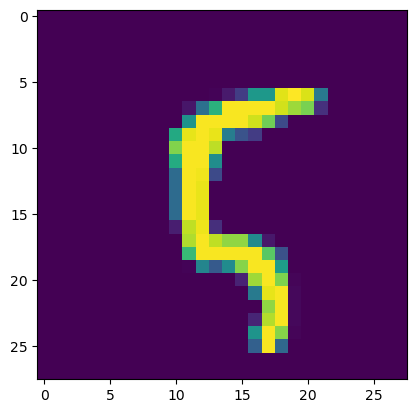

In [14]:
plt.imshow(train_data[100][0][0])

# Create the Model

In [15]:
def create_lenet():
    model = nn.Sequential(
        
        nn.Conv2d(1,6,5,padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        
        nn.Conv2d(6,16,5,padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        
        nn.Flatten(),
        nn.Linear(16*5*5,120),
        nn.ReLU(),
        nn.Linear(120,84), 
        nn.ReLU(),
        nn.Linear(84,10)
        
    )
    return model

# Validate the Model

In [16]:
def validate(model, data):
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.to("cpu")  # Move images to CPU
        x = model(images)
        value, pred = torch.max(x, 1)
        correct += (pred == labels).sum().item()
    accuracy = 100 * correct / len(data.dataset)
    return accuracy

# Train function

In [17]:
def train(num_epoch=3, lr=1e-3,device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(),lr=lr)
    max_accuracy = 0
    
    for epoch in range(num_epoch):
        for i, (images,labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving with Model with Best accuracy", accuracy)
        print("Epoch", epoch+1, "Accuracy", accuracy,"%")
    plt.plot(accuracies)
    return best_model
                

# GPU Availibility

In [18]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
device

device(type='cpu')

# Training the Model

Saving with Model with Best accuracy 95.11
Epoch 1 Accuracy 95.11 %
Saving with Model with Best accuracy 96.92
Epoch 2 Accuracy 96.92 %
Saving with Model with Best accuracy 97.29
Epoch 3 Accuracy 97.29 %
Saving with Model with Best accuracy 98.06
Epoch 4 Accuracy 98.06 %
Saving with Model with Best accuracy 98.61
Epoch 5 Accuracy 98.61 %
Saving with Model with Best accuracy 98.68
Epoch 6 Accuracy 98.68 %
Saving with Model with Best accuracy 98.78
Epoch 7 Accuracy 98.78 %
Epoch 8 Accuracy 98.7 %
Epoch 9 Accuracy 98.62 %
Epoch 10 Accuracy 98.45 %
Saving with Model with Best accuracy 98.85
Epoch 11 Accuracy 98.85 %
Epoch 12 Accuracy 98.64 %
Epoch 13 Accuracy 98.81 %
Epoch 14 Accuracy 98.78 %
Epoch 15 Accuracy 98.75 %
Epoch 16 Accuracy 98.63 %
Epoch 17 Accuracy 98.72 %
Epoch 18 Accuracy 98.6 %
Epoch 19 Accuracy 98.83 %
Epoch 20 Accuracy 98.68 %
Saving with Model with Best accuracy 98.89
Epoch 21 Accuracy 98.89 %
Epoch 22 Accuracy 98.87 %
Epoch 23 Accuracy 98.77 %
Epoch 24 Accuracy 98.67 %


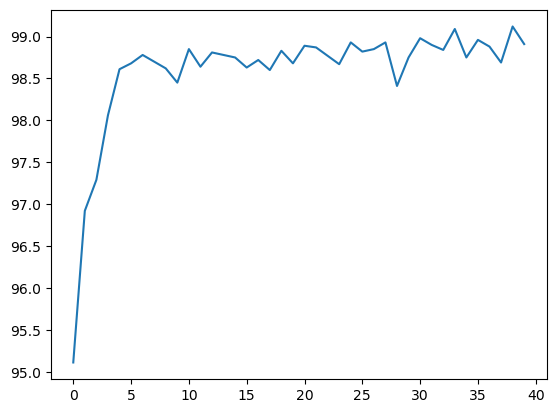

In [71]:
lenet = train(40,device=device)

In [72]:
def predict_dl(model,data):
    y_pred = []
    y_true = [] 
    for i, (images,labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x,1)
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred),np.array(y_true)

In [73]:
y_pred, y_true = predict_dl(lenet,val_dl)

In [74]:
y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [75]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,978,0,0,0,0,0,1,1,0,0
1,0,1133,0,0,0,0,1,0,1,0
2,1,1,1024,0,1,0,0,5,0,0
3,0,0,0,1000,0,6,0,2,1,1
4,0,0,0,0,977,0,1,2,1,1
5,2,0,0,4,0,884,1,0,1,0
6,3,2,0,0,1,3,948,0,1,0
7,0,3,3,0,1,0,0,1019,2,0
8,4,0,1,3,2,2,0,2,957,3
9,0,0,0,0,10,5,0,2,0,992


# Define an inference function

In [76]:
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        image = Image.open(f).convert(mode="L")
        image = image.resize((28,28)) #model only accepts 28 by 28 
        x = (255 - np.expand_dims(np.array(image), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()

In [77]:
 path = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR_-ZIg304UGx64kaQYJB6BJdkFQimNbYzzWlvDgwQ&s|"

In [78]:
r = requests.get(path)
with BytesIO(r.content) as f:
    image = Image.open(f).convert(mode="L")
    image = image.resize((32,32)) #model only accepts 28 by 28 
    x = (255 - np.expand_dims(np.array(image), -1))/255.

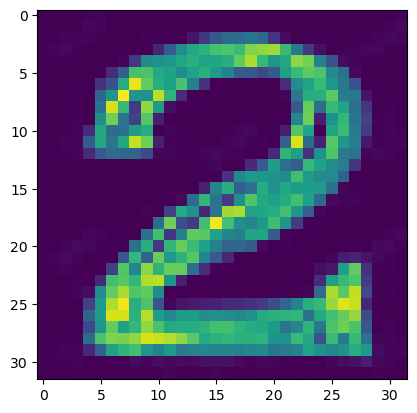

In [79]:
plt.imshow(x.squeeze(-1))

In [80]:
pred = inference(path,lenet,device=device)
pred

array([[1.5596185e-10, 1.0163478e-12, 9.9999785e-01, 9.6809734e-11,
        8.5085925e-23, 4.3294455e-17, 1.6051364e-12, 2.1401103e-13,
        2.1053959e-06, 2.0598696e-15]], dtype=float32)

In [81]:
pred_idx = np.argmax(pred)

In [82]:
print(f"Predicted: {pred_idx} Prob: {pred[0][pred_idx]*100}")

Predicted: 2 Prob: 99.99978542327881


In [83]:
def plot_predictions(pred):
    # Create an array with the number of classes
    classes = np.arange(len(pred))

    # Create a bar plot
    plt.bar(classes, pred)

    # Add title and labels
    plt.title('Prediction Probabilities')
    plt.xlabel('Classes')
    plt.ylabel('Probability')

    # Show the plot
    plt.show()

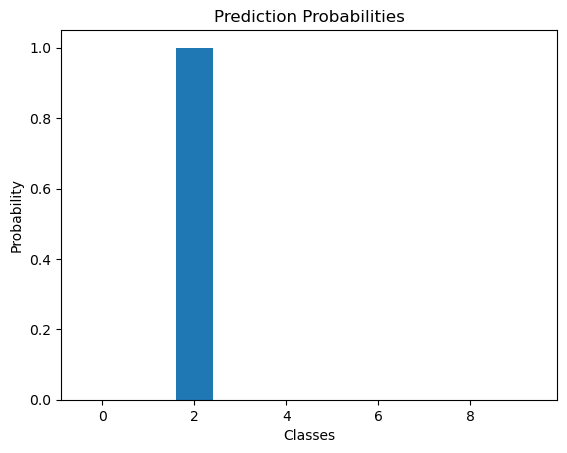

In [84]:
plot_predictions(pred[0])

In [86]:
torch.save(lenet.state_dict(), 'updated_model_weights.pth')